In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import colorsys
import math
%matplotlib inline

#### TABLE HEADERS

    2 CREATE TABLE users  
    (id INTEGER PRIMARY KEY, user_key, datestamp, ip, language, monitor, temperature, gamma, colorblind, ychrom, samplecolors, spamprob);

    152405 CREATE TABLE answers
    (id INTEGER PRIMARY KEY, user_id, datestamp, r, g, b, colorname);

    3560443 CREATE TABLE names  
    (id INTEGER PRIMARY KEY, colorname, numusers, numinstances);

In [2]:
def get_table(header, tablename):
    userdata = []
    userdata_excepts = []
    c = 0
    leadstr = f'INSERT INTO "{tablename}" VALUES'
    with open('mainsurvey_sqldump.txt','r') as f:
        for line in f:
            if line.startswith(leadstr):
                tmp = line.strip(leadstr)[1:-3].split(',')
                if len(tmp)>len(header):
                    c +=1
                    tmp2 = line.strip(leadstr)[1:-1]
                    userdata_excepts.append(tmp2)
                else:
                    userdata.append(tmp)
    tmpdf = pd.DataFrame(userdata)
    tmpdf.columns = header
    return tmpdf, userdata, userdata_excepts

### EXTRACT 'answers' TABLE

In [3]:
header = "id INTEGER PRIMARY KEY, user_id, datestamp, r, g, b, colorname"
header = header.replace(', ', ',').split(',')
df,_ ,_= get_table(header,'answers')

In [4]:
df['datestamp'] = df['datestamp'].apply(lambda x: int(float(x)))
df['r'] = df['r'].apply(lambda x: int(float(x)))
df['g'] = df['g'].apply(lambda x: int(float(x)))
df['b'] = df['b'].apply(lambda x: int(float(x)))
df['rgb'] =list(zip(df.r,df.g,df.b))
df['colorname'] = df['colorname'].apply(lambda x: str(x).lower())
df['colorname'] = df['colorname'].apply(lambda x: x.replace('grey', 'gray'))
df['colorname'] = df['colorname'].apply(lambda x: x[1:-1])
df['user_id'] = df['user_id'].apply(lambda x: int(x))
df.head()

,id INTEGER PRIMARY KEY,user_id,datestamp,r,g,b,colorname,rgb
0,1,1,1267418734,72,100,175,pastel blue,"(72, 100, 175)"
1,2,1,1267418739,204,177,246,faint violet,"(204, 177, 246)"
2,3,1,1267418769,182,226,245,baby blue,"(182, 226, 245)"
3,4,1,1267418773,130,64,234,purple,"(130, 64, 234)"
4,5,2,1267419006,75,49,234,blue,"(75, 49, 234)"


# STATS

In [5]:
n_unique_raters = df['user_id'].nunique()
print(f'No. of users: {n_unique_raters}')

mean_colours_per_rater = len(df)/n_unique_raters
print(f'Mean no. of colours each user rated: {mean_colours_per_rater}')

No. of users: 145021
Mean no. of colours each user rated: 23.442997910647424


#### Session length

In [6]:
session_length = df.groupby('user_id')['datestamp'].max()- df.groupby('user_id')['datestamp'].min()
session_length = session_length.sort_values(ascending = False)
session_length.describe()

count    145021.000000
mean        213.569042
std         333.150700
min           0.000000
25%          65.000000
50%         124.000000
75%         236.000000
max       21140.000000
Name: datestamp, dtype: float64

#### Top k most frequently used colour labels

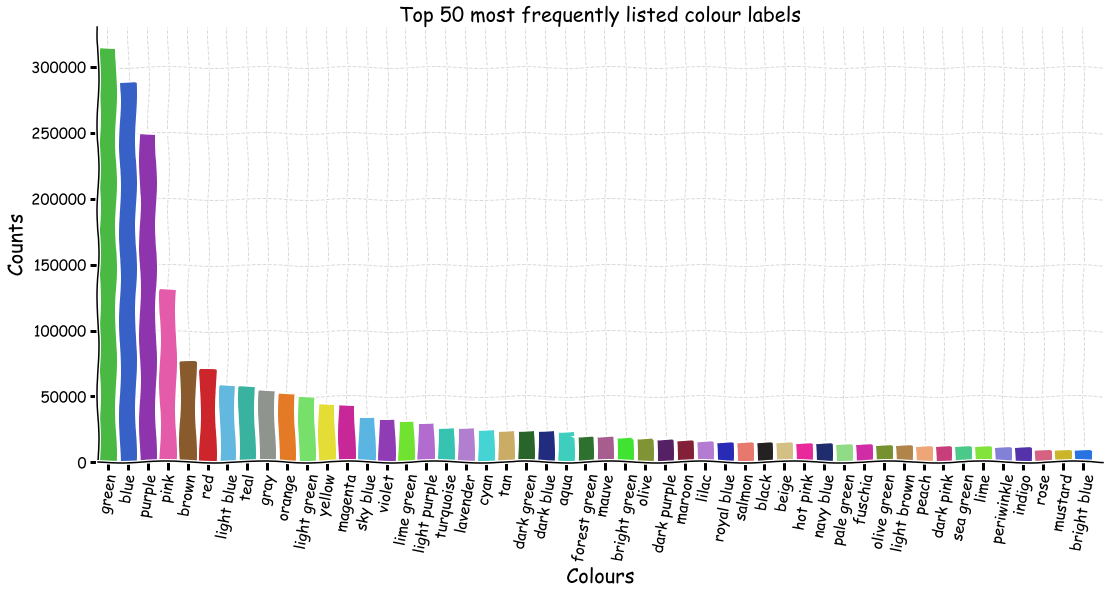

In [7]:
k = 50
topk = df.groupby('colorname')['colorname'].count().sort_values(ascending=False)[:k]
with plt.xkcd():
    f, ax = plt.subplots(figsize=(18,8))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_axisbelow(True)
    plt.xlim(-0.5,k)
    plt.grid(color='xkcd:light grey', linestyle='--', linewidth=1)

    for i in range(k):
        avg = df[df['colorname']==topk.keys()[i]][['r','g','b']].mean().values / 255
        plt.bar(i, topk.values[i],color=tuple(avg));

    plt.xticks(range(k),list(topk.keys()),rotation=80);
    plt.title(f'Top {k} most frequently listed colour labels',size=20)
    plt.xlabel('Colours', size=20)
    plt.ylabel('Counts', size=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.show()

# VISUALISING THE COLOURS

In [5]:
def get_colours(df, colourname,showimg=True, output=False, imgdim=3):
    
    targ_colour = df[df['colorname'].str.contains(colourname) == True]['rgb'].values
    print(f'{len(targ_colour)} colours  with "{colourname}" in colourname found')
    pad = math.ceil(len(targ_colour)**0.5)
    diff = abs(len(targ_colour) - (pad**2))
    
    list_of_pixels = list(targ_colour) + [(0,0,0)]*diff
    list_of_pixels.sort(key=lambda rgb: colorsys.rgb_to_hsv(*rgb) )
    # list_of_pixels= sorted(list_of_pixels, key=lambda x: (x[0],x[1],x[2]))
    im2 = Image.new('RGB', (pad,pad))
    im2.putdata(list_of_pixels)
    if showimg:
        plt.figure(figsize = (imgdim,imgdim))
        plt.imshow(im2)
        plt.axis('off')
        plt.grid('off');
    if output:
        return im2

In [6]:
def average_color(df, colourname, showimg=True, output=False, imgdim = 3):
    
    avg = df[df['colorname'].str.contains(colourname) == True][['r','g','b']].mean().values.tolist()
    avg = tuple(int(i) for i in avg)
    print(f'Average perceived "{colourname}": {avg}')
    avgimg = Image.new('RGB',(1,1))
    avgimg.putdata([avg]*1)
    if showimg:
        plt.figure(figsize = (imgdim,imgdim))
        plt.imshow(avgimg);
        plt.axis('off')
        plt.grid('off');
    if output:
        return avgimg

In [7]:
def plot_colors(df,clr = 'red'):
    all_clr = get_colours(df,clr,showimg=False,output=True);
    avg_clr = average_color(df,clr,showimg=False,output=True);

    f = plt.figure(figsize=(10,5))

    f.add_subplot(1,2, 1)
    plt.imshow(all_clr)
    plt.axis('off')
    plt.grid('off');
    plt.title(f'ALL COLOURS LABELLED {clr.upper()}')

    f.add_subplot(1,2, 2)
    plt.imshow(avg_clr);
    plt.axis('off')
    plt.grid('off')
    plt.title(f'AVERAGE PERCEIVED {clr.upper()}');

## ALL COLORS 

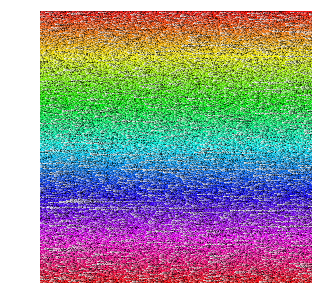

In [8]:
list_of_pixels = list(df['rgb'].values) + [(0,0,0)]*609
list_of_pixels.sort(key=lambda rgb: colorsys.rgb_to_hsv(*rgb) )
# list_of_pixels= sorted(list_of_pixels, key=lambda x: (x[0]))
im2 = Image.new('RGB', (1844,1844))
im2.putdata(list_of_pixels)

plt.figure(figsize = (5,5))
plt.imshow(im2)
plt.axis('off')
plt.grid('off');

## COLOURS WITH "BLUE" IN LABEL

630880 colours  with "blue" in colourname found
Average perceived "blue": (67, 115, 191)


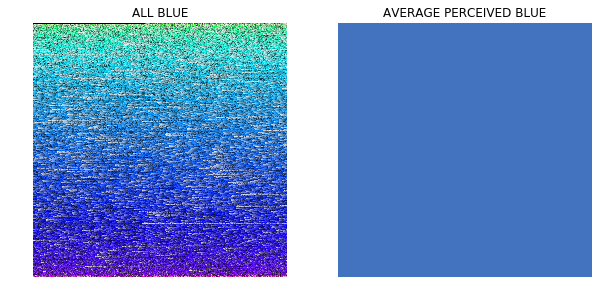

In [9]:
plot_colors(df,'blue')

## COLOURS WITH "RED" IN LABEL

141776 colours  with "red" in colourname found
Average perceived "red": (193, 46, 52)


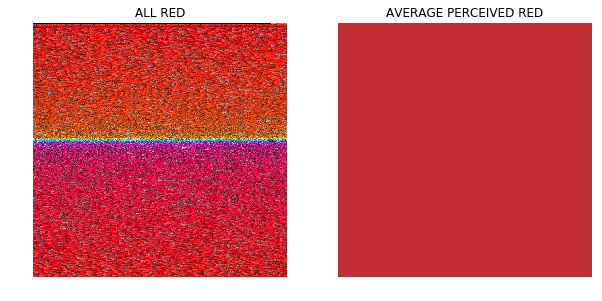

In [10]:
plot_colors(df,'red')

## COLOURS WITH "GREEN" IN LABEL

753881 colours  with "green" in colourname found
Average perceived "green": (87, 186, 76)


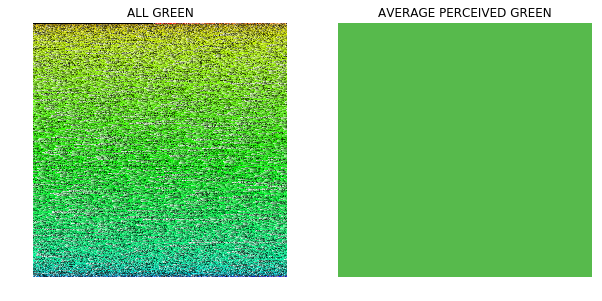

In [11]:
plot_colors(df,'green')

## COLOURS WITH "YELLOW" IN LABEL

111703 colours  with "yellow" in colourname found
Average perceived "yellow": (207, 212, 57)


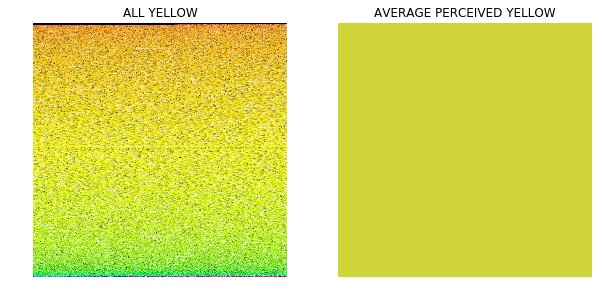

In [12]:
plot_colors(df,'yellow')

## COLOURS WITH "LIGHT" AND "DARK" IN LABEL

237425 colours  with "light" in colourname found
Average perceived "light": (140, 175, 164)
162527 colours  with "dark" in colourname found
Average perceived "dark": (90, 77, 88)


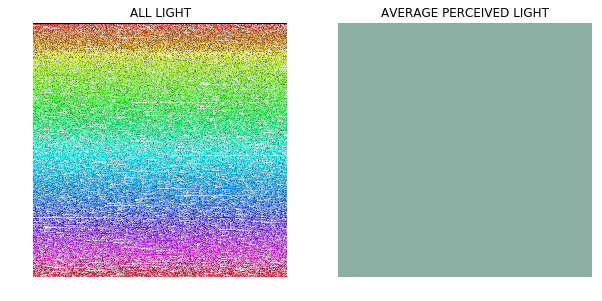

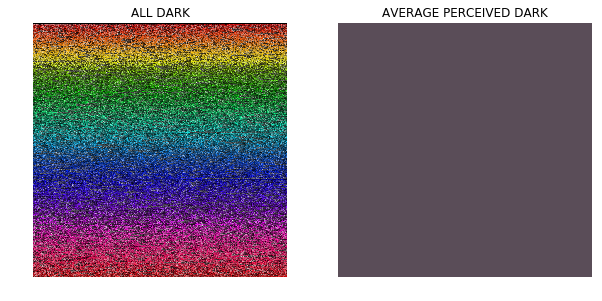

In [13]:
plot_colors(df,'light')
plot_colors(df,'dark')

## COLOURS WITH "PURPLE" IN LABEL

388432 colours  with "purple" in colourname found
Average perceived "purple": (142, 59, 171)


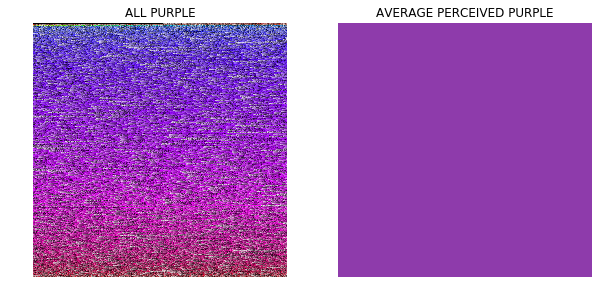

In [38]:
plot_colors(df,'purple')

## COLOURS WITH "TEAL" IN LABEL

75103 colours  with "teal" in colourname found
Average perceived "teal": (58, 175, 155)


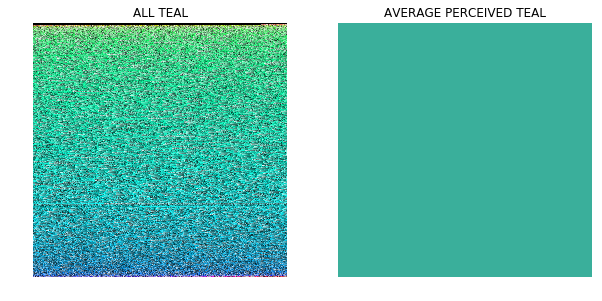

In [35]:
plot_colors(df,'teal')